In [56]:
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [57]:
class CVAE(nn.Module):
    def __init__(self, input_size, num_cl):
        super().__init__()
        self.num_cl = num_cl
        self.input_size = input_size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 64),
            nn.ReLU(True)
        )
        self.mu = nn.Linear(64,64)
        self.log_var = nn.Linear(64,64)
        self.decoder = nn.Sequential(
            nn.Linear(64 + self.num_cl, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, self.input_size),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        enc = self.encoder(x)
        mu = self.mu(enc)
        log_var = self.log_var(enc)
        return enc, mu, log_var
    
    def reparameterize(self, mu, log_var):
        stdev = torch.exp(0.5*log_var)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev
    
    def condition(self, x, y):
        one_hot = F.one_hot(y, num_classes=self.num_cl)
        return torch.concatenate([x, one_hot], dim=1)
    
    def forward(self, x, y):
        _, mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        z_c = self.condition(z, y)
        decoded = self.decoder(z_c)
        return decoded, mu, log_var
        
        

In [58]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') # BCE = -Negative Log-likelihood
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    return BCE + KLD

In [59]:
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 900
lr = 5e-5

train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor()])

train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)


In [60]:
cvae = CVAE(input_size=28*28, num_cl=10).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=lr)

In [61]:
cvae.train()
loss_list = []
for e in tqdm(range(epochs)):
    for x, y in train_loader:
        x = x.view(x.shape[0], -1)
        x, y = x.to(device), y.to(device)
        recon_x, mu, log_var = cvae(x, y)
        loss = vae_loss(recon_x, x, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        

100%|█████████████████████████████████████████| 900/900 [32:45<00:00,  2.18s/it]


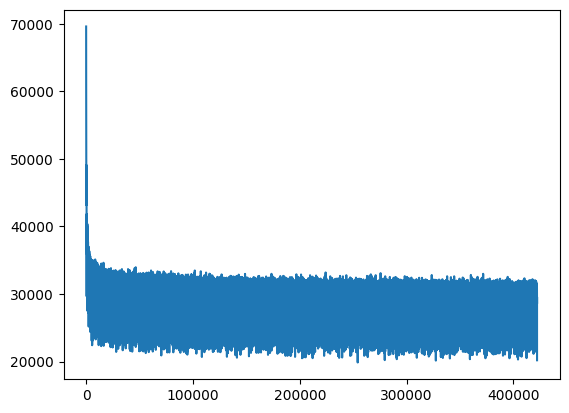

In [62]:
plt.plot(loss_list)

In [63]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    fig.show()

/tmp/ipykernel_8958/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


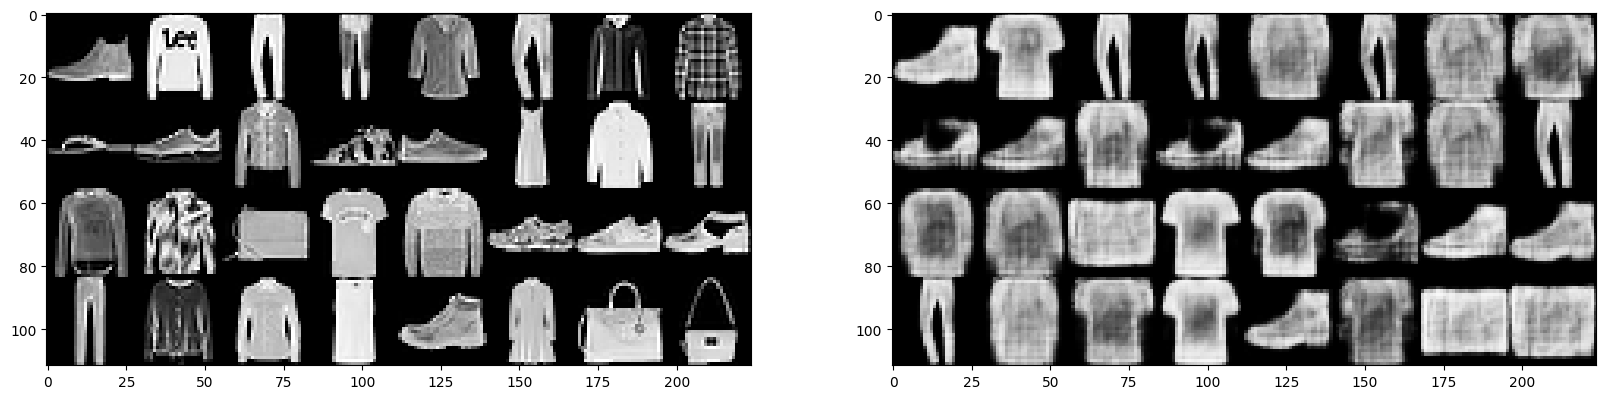

In [64]:
data,y = next(iter(test_loader))
data, y =  data[:32], y[:32]
data_size = data.size()
data, y = data.view(data.size(0),-1).to(device), y.to(device)
output, _, _ = cvae(torch.rand_like(data), y)
output = output.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

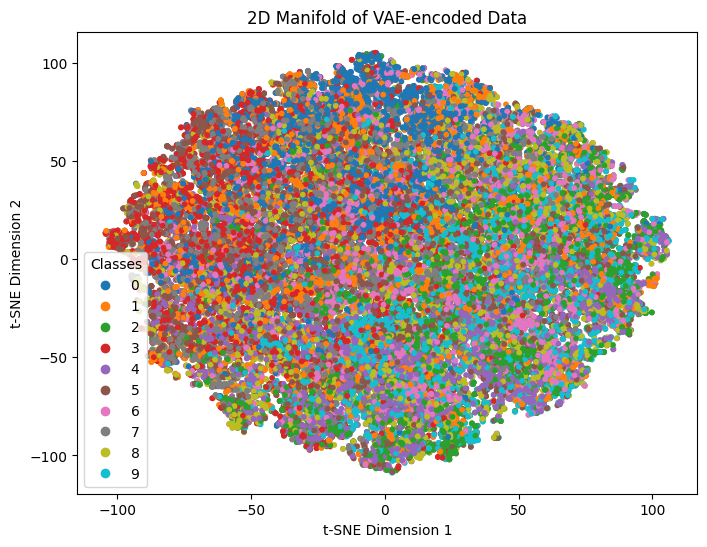

In [65]:
cvae.eval()
encoded_data = []
labels = []
with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        _, mu, _ = cvae.encode(data.view(-1, 784))
        encoded_data.append(mu)
        labels.append(label)

encoded_data = torch.cat(encoded_data, dim=0)
labels = torch.cat(labels, dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(encoded_data.cpu())

# Plot the 2D manifold
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=10)
plt.title('2D Manifold of VAE-encoded Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()


In [66]:
def plot_images(model, class_label, num_images=10):
    latent_vectors = torch.randn(num_images, 64).to(device)
    class_tensor = torch.Tensor([class_label]*num_images).to(torch.int64).to(device)
    print(class_tensor.shape)
    print(class_tensor)
    input_tensor = model.condition(latent_vectors, class_tensor)

    # Decode and reshape the output
    with torch.no_grad():
        generated_images = model.decoder(input_tensor).view(num_images, 1, 28, 28)

    # Plot the generated images
    plt.figure(figsize=(15, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()


torch.Size([10])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')


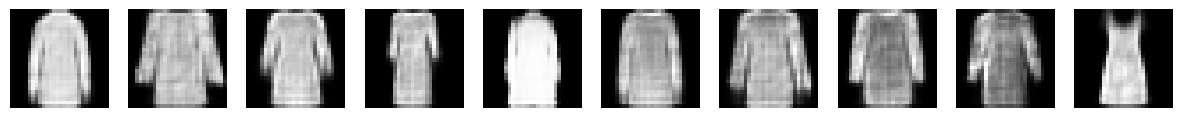

In [67]:
plot_images(cvae, class_label=3)

torch.Size([10])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


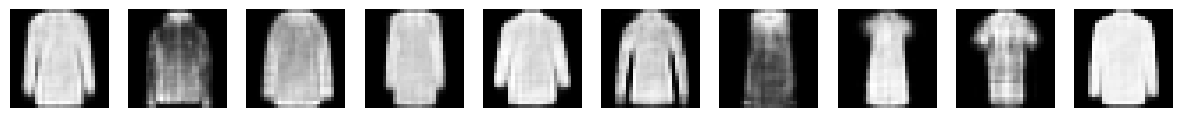

In [68]:
plot_images(cvae, class_label=4)

torch.Size([10])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')


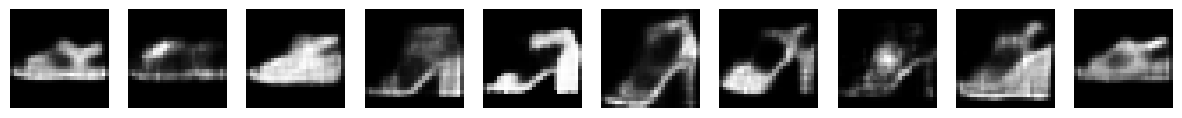

In [69]:
plot_images(cvae, class_label=5)

torch.Size([10])
tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')


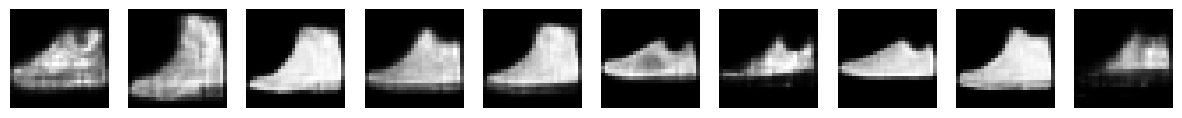

In [70]:
plot_images(cvae, class_label=7)

# VAE

In [71]:
class VAE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.encoder = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 64),
            nn.ReLU(True)
        )
        self.mu = nn.Linear(64,64)
        self.log_var = nn.Linear(64,64)
        self.decoder = nn.Sequential(
            nn.Linear(64, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, self.input_size),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        enc = self.encoder(x)
        mu = self.mu(enc)
        log_var = self.log_var(enc)
        return enc, mu, log_var
    
    def reparameterize(self, mu, log_var):
        stdev = torch.exp(0.5*log_var)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev
    
    def forward(self, x):
        _, mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var
        

In [76]:
vae = VAE(input_size=28*28).to(device)
optimizer = optim.Adam(vae.parameters(), lr=5e-6)

100%|█████████████████████████████████████████| 900/900 [32:06<00:00,  2.14s/it]
/tmp/ipykernel_8958/2568326077.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


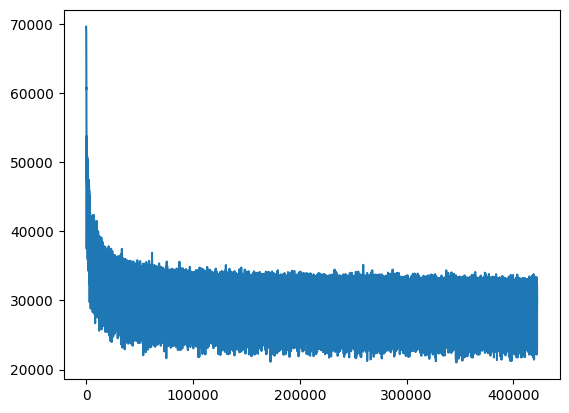

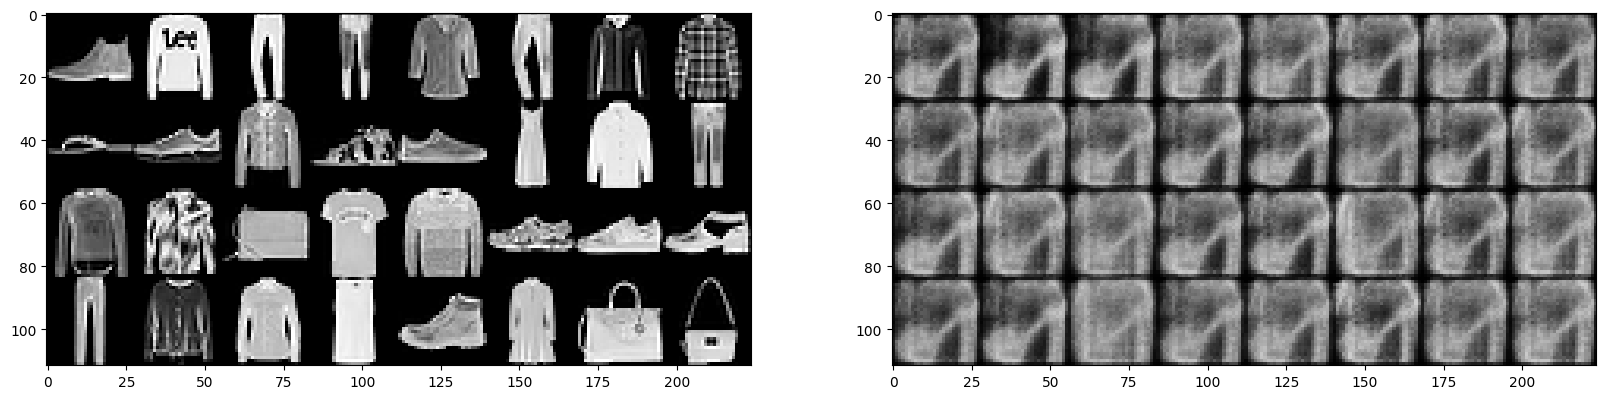

In [77]:
vae.train()
loss_list = []
for e in tqdm(range(epochs)):
    for x, y in train_loader:
        x = x.view(x.shape[0], -1)
        x = x.to(device)
        recon_x, mu, log_var = vae(x)
        loss = vae_loss(recon_x, x, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
plt.plot(loss_list)
data,y = next(iter(test_loader))
data, y =  data[:32], y[:32]
data_size = data.size()
data, y = data.view(data.size(0),-1).to(device), y.to(device)
output, _, _ = vae(torch.rand_like(data))
output = output.detach()
show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

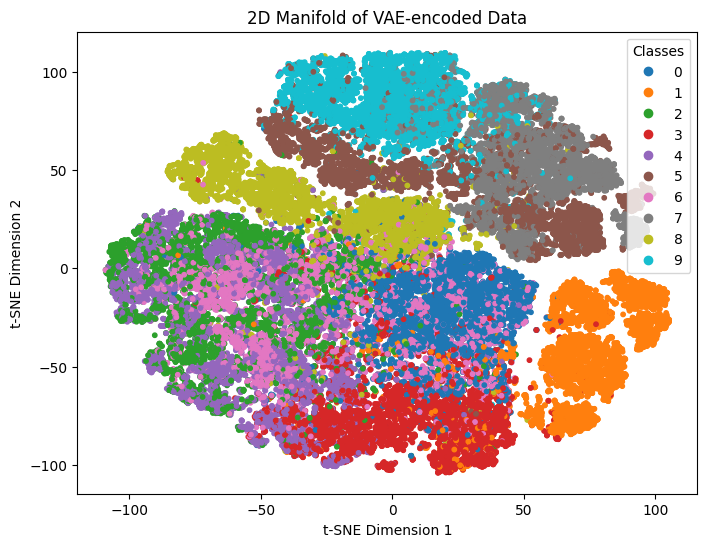

In [74]:
vae.eval()
encoded_data = []
labels = []
with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        _, mu, _ = vae.encode(data.view(-1, 784))
        encoded_data.append(mu)
        labels.append(label)

encoded_data = torch.cat(encoded_data, dim=0)
labels = torch.cat(labels, dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(encoded_data.cpu())

# Plot the 2D manifold
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', s=10)
plt.title('2D Manifold of VAE-encoded Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

### Difference between manifold of CVAE and VAE

From the plot it can be seen that points on VAE manifold are segregated better than CVAE in terms on class. Honestly I assumed that reverse would happen but this plots may be due to the fact that we are explicilty providing class information to CVAE hence, cvae encoder may not be focued on class specific feature but instead encoding other features like length, shape etc. 